In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from finvizfinance.quote import finvizfinance
from finvizfinance.screener.overview import Overview

from scipy.spatial.distance import cdist,pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import sklearn.decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

import xgboost

In [227]:
pd.set_option('display.max_columns', 500)
sns.set(style='white', context='notebook', rc={'figure.figsize':(20,12),'figure.dpi':(300)})

In [228]:
df1 = pd.read_csv('Data(Finviz)/data2021-07-13.csv', index_col=0, thousands=',')
df2 = pd.read_csv('Data(Finviz)/pag1.csv', index_col=0, thousands=',')

In [229]:
df1.set_index(df1['No.'], inplace=True)
df1.drop(df1.columns[0:1], axis = 1, inplace = True)

In [230]:
df1 = df2.append(df1)

In [231]:
df1 = df1.astype('str').replace({'-':None})

In [232]:
display(df1)

,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,PEG,P/B,EPS this Y,EPS past 5Y,Sales Q/Q,Inst Own,ROA,ROE,ROI,Quick R,Debt/Eq,Oper M,Perf Year,Volatility M,SMA20,SMA50,SMA200,50D High,50D Low,52W High,52W Low,RSI,Recom,Avg Volume,Price,Change,Volume
No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,GME,GameStop Corp.,Consumer Cyclical,Specialty Retail,USA,13.60B,None,None,14.20,37.80%,-23.50%,25.10%,41.10%,-4.70%,-23.30%,-22.80%,0.90,0.05,-3.20%,4260.60%,7.38%,-12.17%,-10.67%,69.04%,-46.72%,34.53%,-61.98%,4770.95%,38.58,4.00,7.03M,183.63,-2.97%,1296703
2,GBOX,GreenBox POS,Technology,Software - Infrastructure,USA,503.74M,None,None,8.57,-500.60%,-62.40%,None,2.90%,-62.80%,-145.10%,-319.00%,8.80,0.01,None,3734.34%,9.46%,-11.31%,-2.51%,33.07%,-31.21%,52.76%,-45.38%,4469.24%,42.99,None,1.01M,11.35,-1.13%,210178
3,SAVA,"Cassava Sciences, Inc.",Healthcare,Biotechnology,USA,4.42B,None,None,13.33,8.80%,35.40%,None,27.70%,-8.10%,-8.30%,None,107.10,0.00,None,2878.11%,11.38%,21.67%,60.48%,195.01%,-7.94%,189.26%,-11.28%,3651.08%,68.61,2.00,2.20M,104.28,4.99%,1550618
4,OCGN,"Ocugen, Inc.",Healthcare,Biotechnology,USA,1.43B,None,None,27.92,79.00%,70.80%,None,12.60%,-119.50%,-154.50%,None,12.00,0.05,None,3125.51%,9.61%,-7.17%,-19.90%,34.16%,-57.72%,14.93%,-63.51%,3602.76%,41.41,2.70,68.48M,6.85,-1.86%,9259799
5,MOXC,"Moxian, Inc.",Communication Services,Internet Content & Information,Hong Kong,547.60M,None,None,208.50,-75.80%,15.00%,None,1.90%,-94.70%,-281.00%,9.10%,2.70,0.04,None,2680.00%,24.75%,49.17%,98.16%,448.98%,-6.46%,405.23%,-6.46%,3519.45%,74.52,None,3.39M,29.35,0.56%,1409360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8036,LSST,Natixis Loomis Sayles Short Duration Income ETF,Financial,Exchange Traded Fund,USA,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2.28%,0.05%,-0.01%,-0.02%,-1.39%,-0.18%,0.70%,-3.50%,0.70%,46.84,None,10.61K,25.25,-0.02%,3908
8037,SCHJ,Schwab 1-5 Year Corporate Bond ETF,Financial,Exchange Traded Fund,USA,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.63%,0.16%,-0.02%,-0.05%,0.02%,-0.56%,0.25%,-6.95%,0.69%,47.36,None,98.55K,51.16,-0.04%,23929
8038,FTSD,Franklin Liberty Short Duration U.S. Governmen...,Financial,Exchange Traded Fund,USA,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-1.05%,0.15%,-0.06%,-0.27%,-0.67%,-0.54%,0.69%,-2.81%,0.69%,39.69,None,26.93K,94.85,0.02%,5354


In [233]:
df1 = df1.drop(['PEG','P/E','Oper M','Quick R','EPS past 5Y'], axis=1)

In [234]:
#Market Cap to scale of billions
d = {'M': '', 'B': '*1000'}
df1['Market Cap'] = df1['Market Cap'].loc[df1['Market Cap'].notna()].astype('str').replace(d, regex=True, method=None).map(pd.eval)

e = {'K': '', 'M': '*1000'}
df1['Avg Volume'] = df1['Avg Volume'].replace(e, regex=True).map(pd.eval)
#Recommendations to numbers
df1["Recom"] = pd.to_numeric(df1["Recom"], downcast="float")
#Volume to numbers
df1["Volume"] = df1["Volume"].astype(int)
df1["Price"] = df1["Price"].astype(float)
df1["RSI"] = df1["RSI"].astype(float)
df1["P/B"] = df1["P/B"].astype(float)
df1["Debt/Eq"] = df1["Debt/Eq"].astype(float)

#Percentages to floats
colList = ['EPS this Y', 'Sales Q/Q', 'Inst Own', 'ROA', 'ROE', 'ROI', 
           'Perf Year', 'Volatility M', 'SMA20', 'SMA50', 'SMA200',
          '50D High', '50D Low', '52W High', '52W Low', 'Change']
for x in colList:
    df1[x] = df1[x].str.rstrip('%').astype('float')/100
    
print(df1.dtypes)

Ticker           object
Company          object
Sector           object
Industry         object
Country          object
Market Cap      float64
P/B             float64
EPS this Y      float64
Sales Q/Q       float64
Inst Own        float64
ROA             float64
ROE             float64
ROI             float64
Debt/Eq         float64
Perf Year       float64
Volatility M    float64
SMA20           float64
SMA50           float64
SMA200          float64
50D High        float64
50D Low         float64
52W High        float64
52W Low         float64
RSI             float64
Recom           float32
Avg Volume      float64
Price           float64
Change          float64
Volume            int64
dtype: object


In [235]:
industries = ['Capital Markets', 'Software - Infrastructure', 'Scientific & Technical Instruments', 'Software - Application', 'Oil & Gas Refining & Marketing', 'Internet Retail', 'Solar', 'Biotechnology', 'Internet Content & Information', 'Electronic Components', 'Furnishings, Fixtures & Appliances', 'Consumer Electronics', 'Diagnostics & Research', 'Auto Manufacturers', 'Specialty Industrial Machinery', 'Exchange Traded Fund', 'Aerospace & Defense', 'Farm & Heavy Construction Machinery', 'Communication Equipment', 'Specialty Chemicals', 'Semiconductor Equipment & Materials', 'Packaging & Containers', 'Security & Protection Services', 'Oil & Gas E&P', 'Residential Construction', 'Banks - Regional', 'Marine Shipping', 'Electronic Gaming & Multimedia', 'Home Improvement Retail', 'Computer Hardware', 'Oil & Gas Equipment & Services', 'Other Industrial Metals & Mining', 'Auto & Truck Dealerships', 'Real Estate Services', 'Electrical Equipment & Parts', 'Rental & Leasing Services', 'Utilities - Diversified', 'Pollution & Treatment Controls', 'Resorts & Casinos', 'Recreational Vehicles', 'Steel', 'Waste Management', 'Medical Devices', 'Auto Parts', 'Building Products & Equipment', 'Medical Instruments & Supplies', 'Chemicals', 'Oil & Gas Drilling', 'Conglomerates', 'Paper & Paper Products', 'Entertainment', 'Packaged Foods', 'Engineering & Construction', 'Medical Care Facilities', 'Information Technology Services', 'Staffing & Employment Services', 'Asset Management', 'Shell Companies', 'Publishing', 'Oil & Gas Integrated', 'Trucking', 'Mortgage Finance', 'Agricultural Inputs', 'Railroads', 'Telecom Services', 'Education & Training Services', 'Oil & Gas Midstream', 'Broadcasting', 'Household & Personal Products', 'Medical Distribution', 'Footwear & Accessories', 'Health Information Services', 'Airlines', 'Credit Services', 'Uranium', 'Industrial Distribution', 'Business Equipment & Supplies', 'Textile Manufacturing', 'Semiconductors', 'Utilities - Regulated Gas', 'Aluminum', 'Travel Services', 'REIT - Retail', 'Thermal Coal', 'Farm Products', 'Specialty Business Services', 'Copper', 'Discount Stores', 'REIT - Hotel & Motel', 'Department Stores', 'REIT - Mortgage', 'Personal Services', 'Integrated Freight & Logistics', 'REIT - Diversified', 'Building Materials', 'Silver', 'Metal Fabrication', 'Real Estate - Diversified', 'Lumber & Wood Production', 'Insurance - Reinsurance', 'Gold', 'Real Estate - Development', 'Food Distribution', 'Financial Conglomerates', 'REIT - Residential', 'Closed-End Fund - Equity', 'Other Precious Metals & Mining', 'REIT - Specialty', 'Airports & Air Services', 'Banks - Diversified', 'Insurance - Specialty', 'Lodging', 'Drug Manufacturers - General', 'Insurance - Diversified', 'Tools & Accessories', 'Coking Coal', 'REIT - Industrial', 'Insurance - Life', 'Tobacco', 'Closed-End Fund - Debt', 'REIT - Healthcare Facilities', 'Utilities - Regulated Electric', 'Grocery Stores', 'Consulting Services', 'Insurance - Property & Casualty', 'Healthcare Plans', 'Electronics & Computer Distribution', 'Utilities - Renewable', 'Financial Data & Stock Exchanges', 'Closed-End Fund - Foreign', 'Infrastructure Operations', 'REIT - Office', 'Utilities - Independent Power Producers', 'Utilities - Regulated Water']

In [236]:
ind_gby  = {}
sec_gby  = {}
ctry_gby = {}
for industry in industries:
    ind_gby[industry] = df1.groupby('Industry').get_group(industry)
    
for sector in df3['Sector']:
    sec_gby[sector]   = df1.groupby('Sector').get_group(sector)
    
for country in df3['Country']:
    ctry_gby[country] = df1.groupby('Country').get_group(country)

In [237]:
reit = ind_gby['REIT - Office']

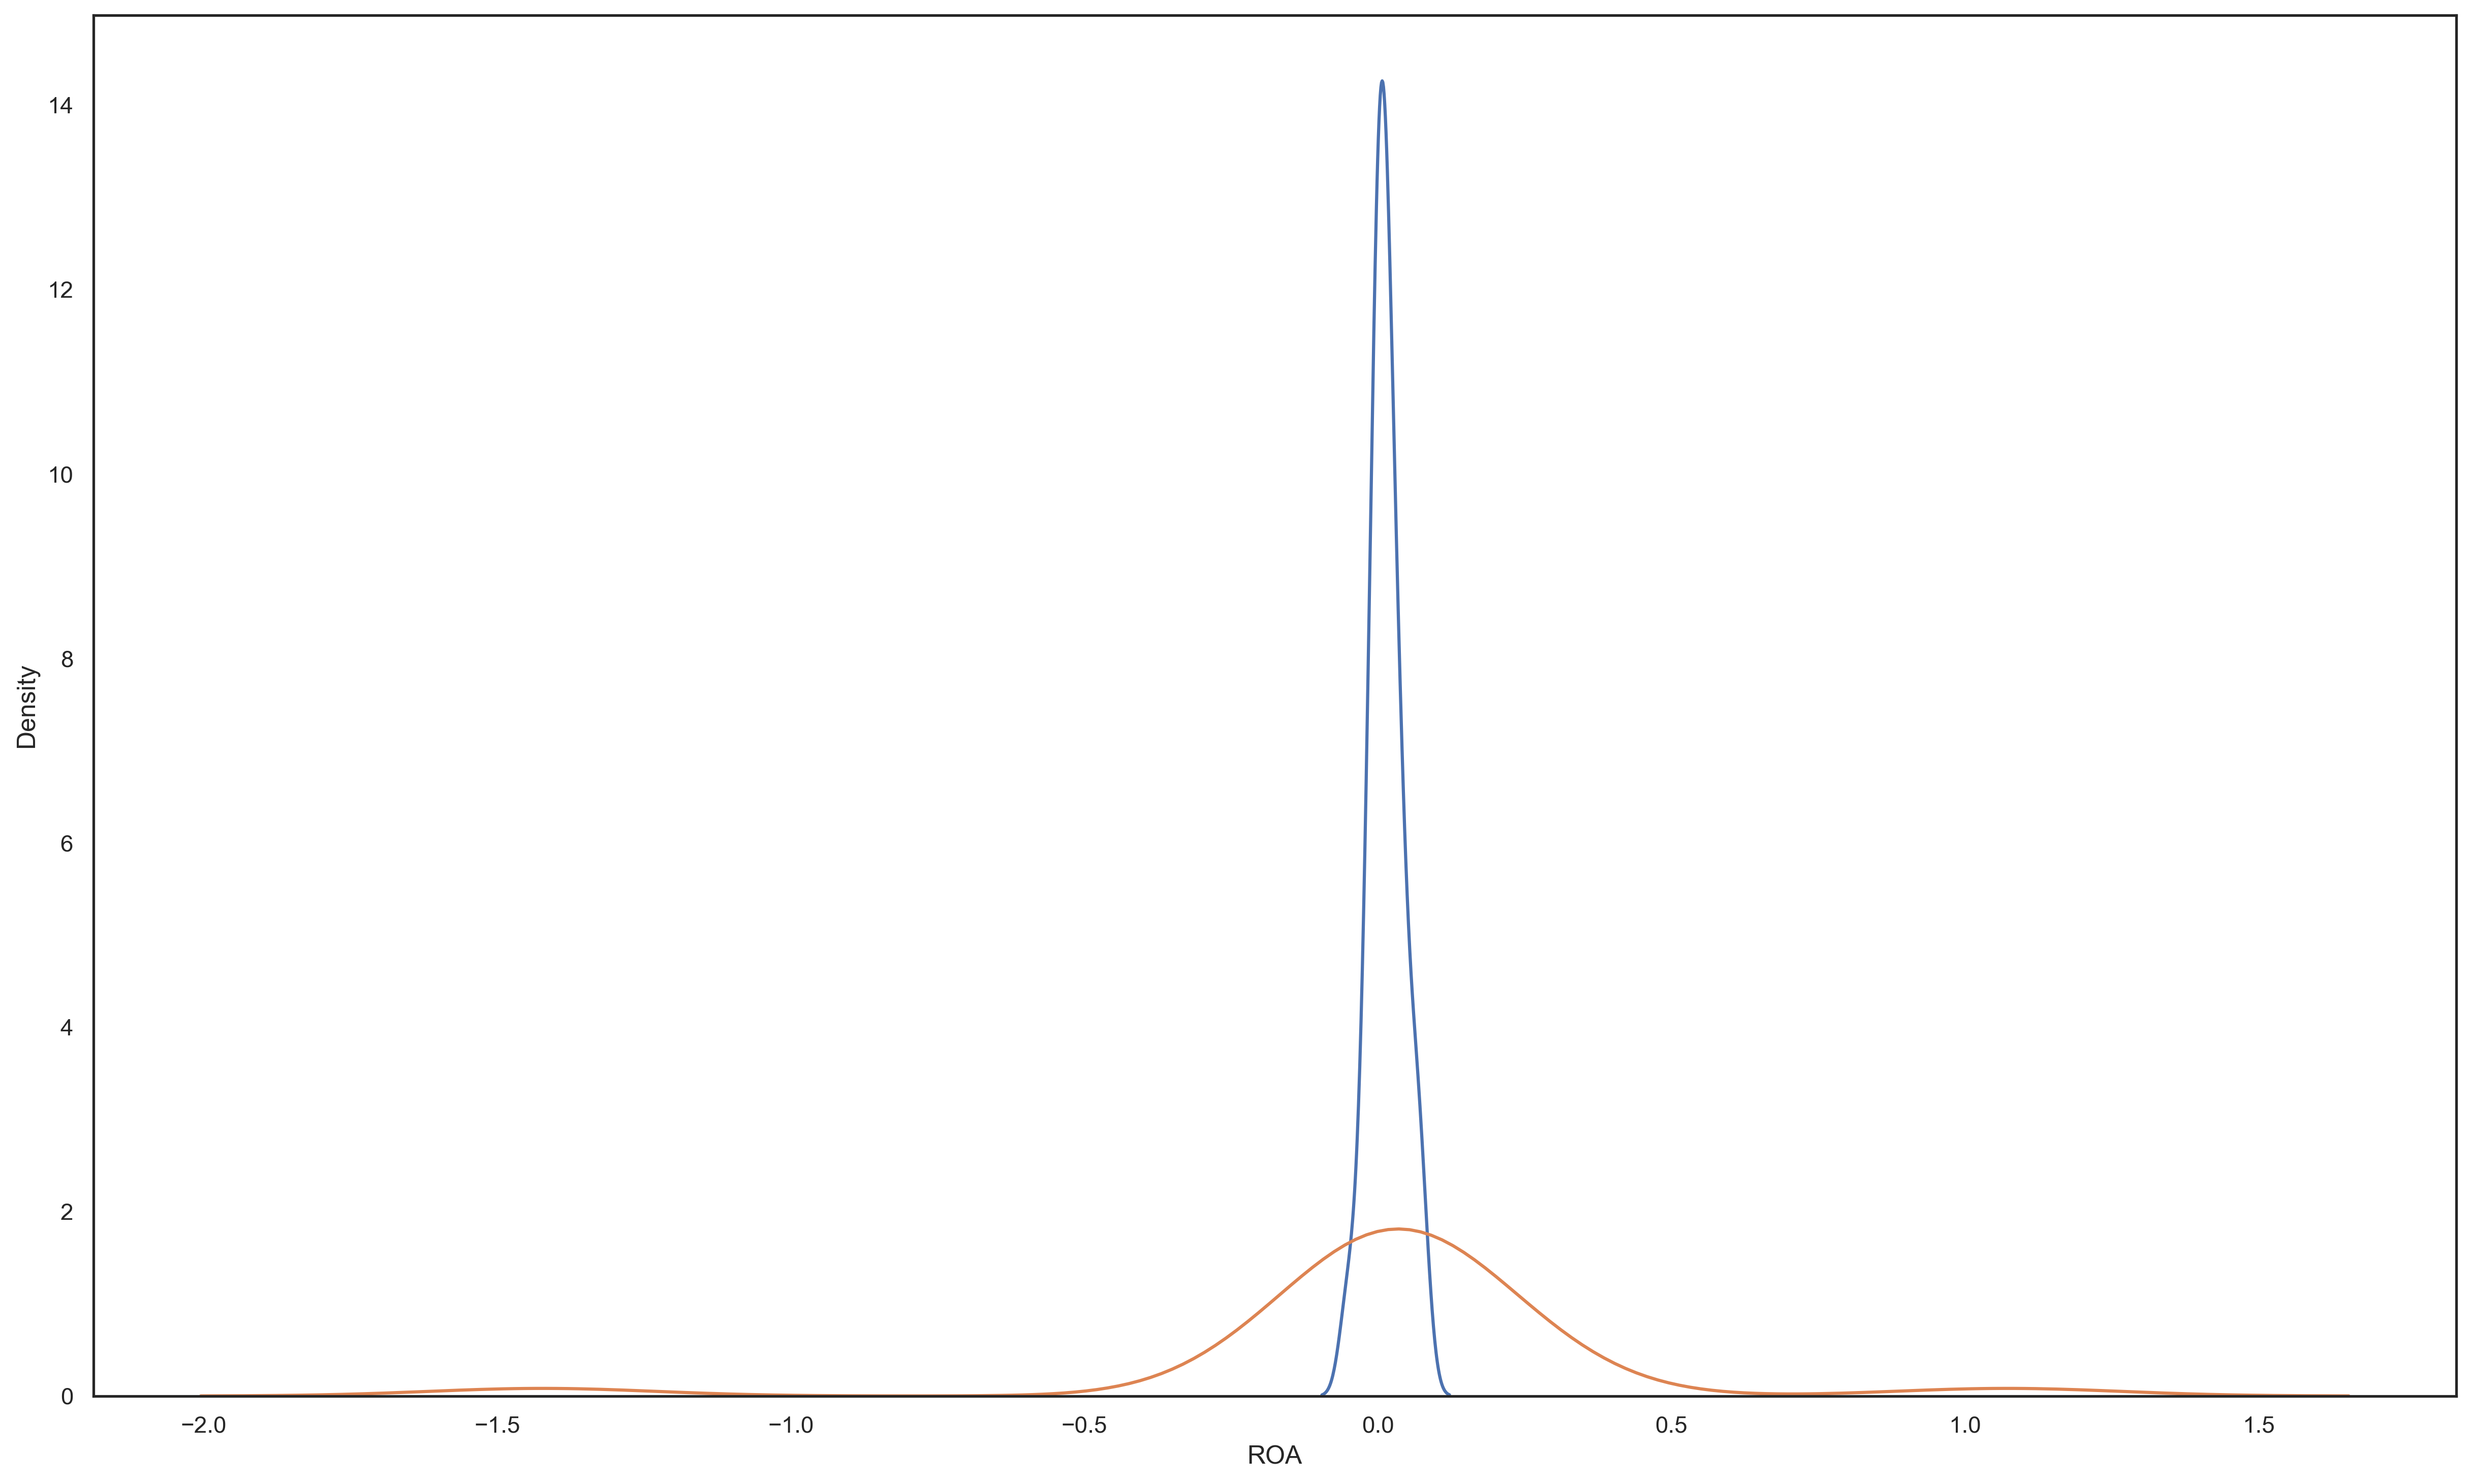

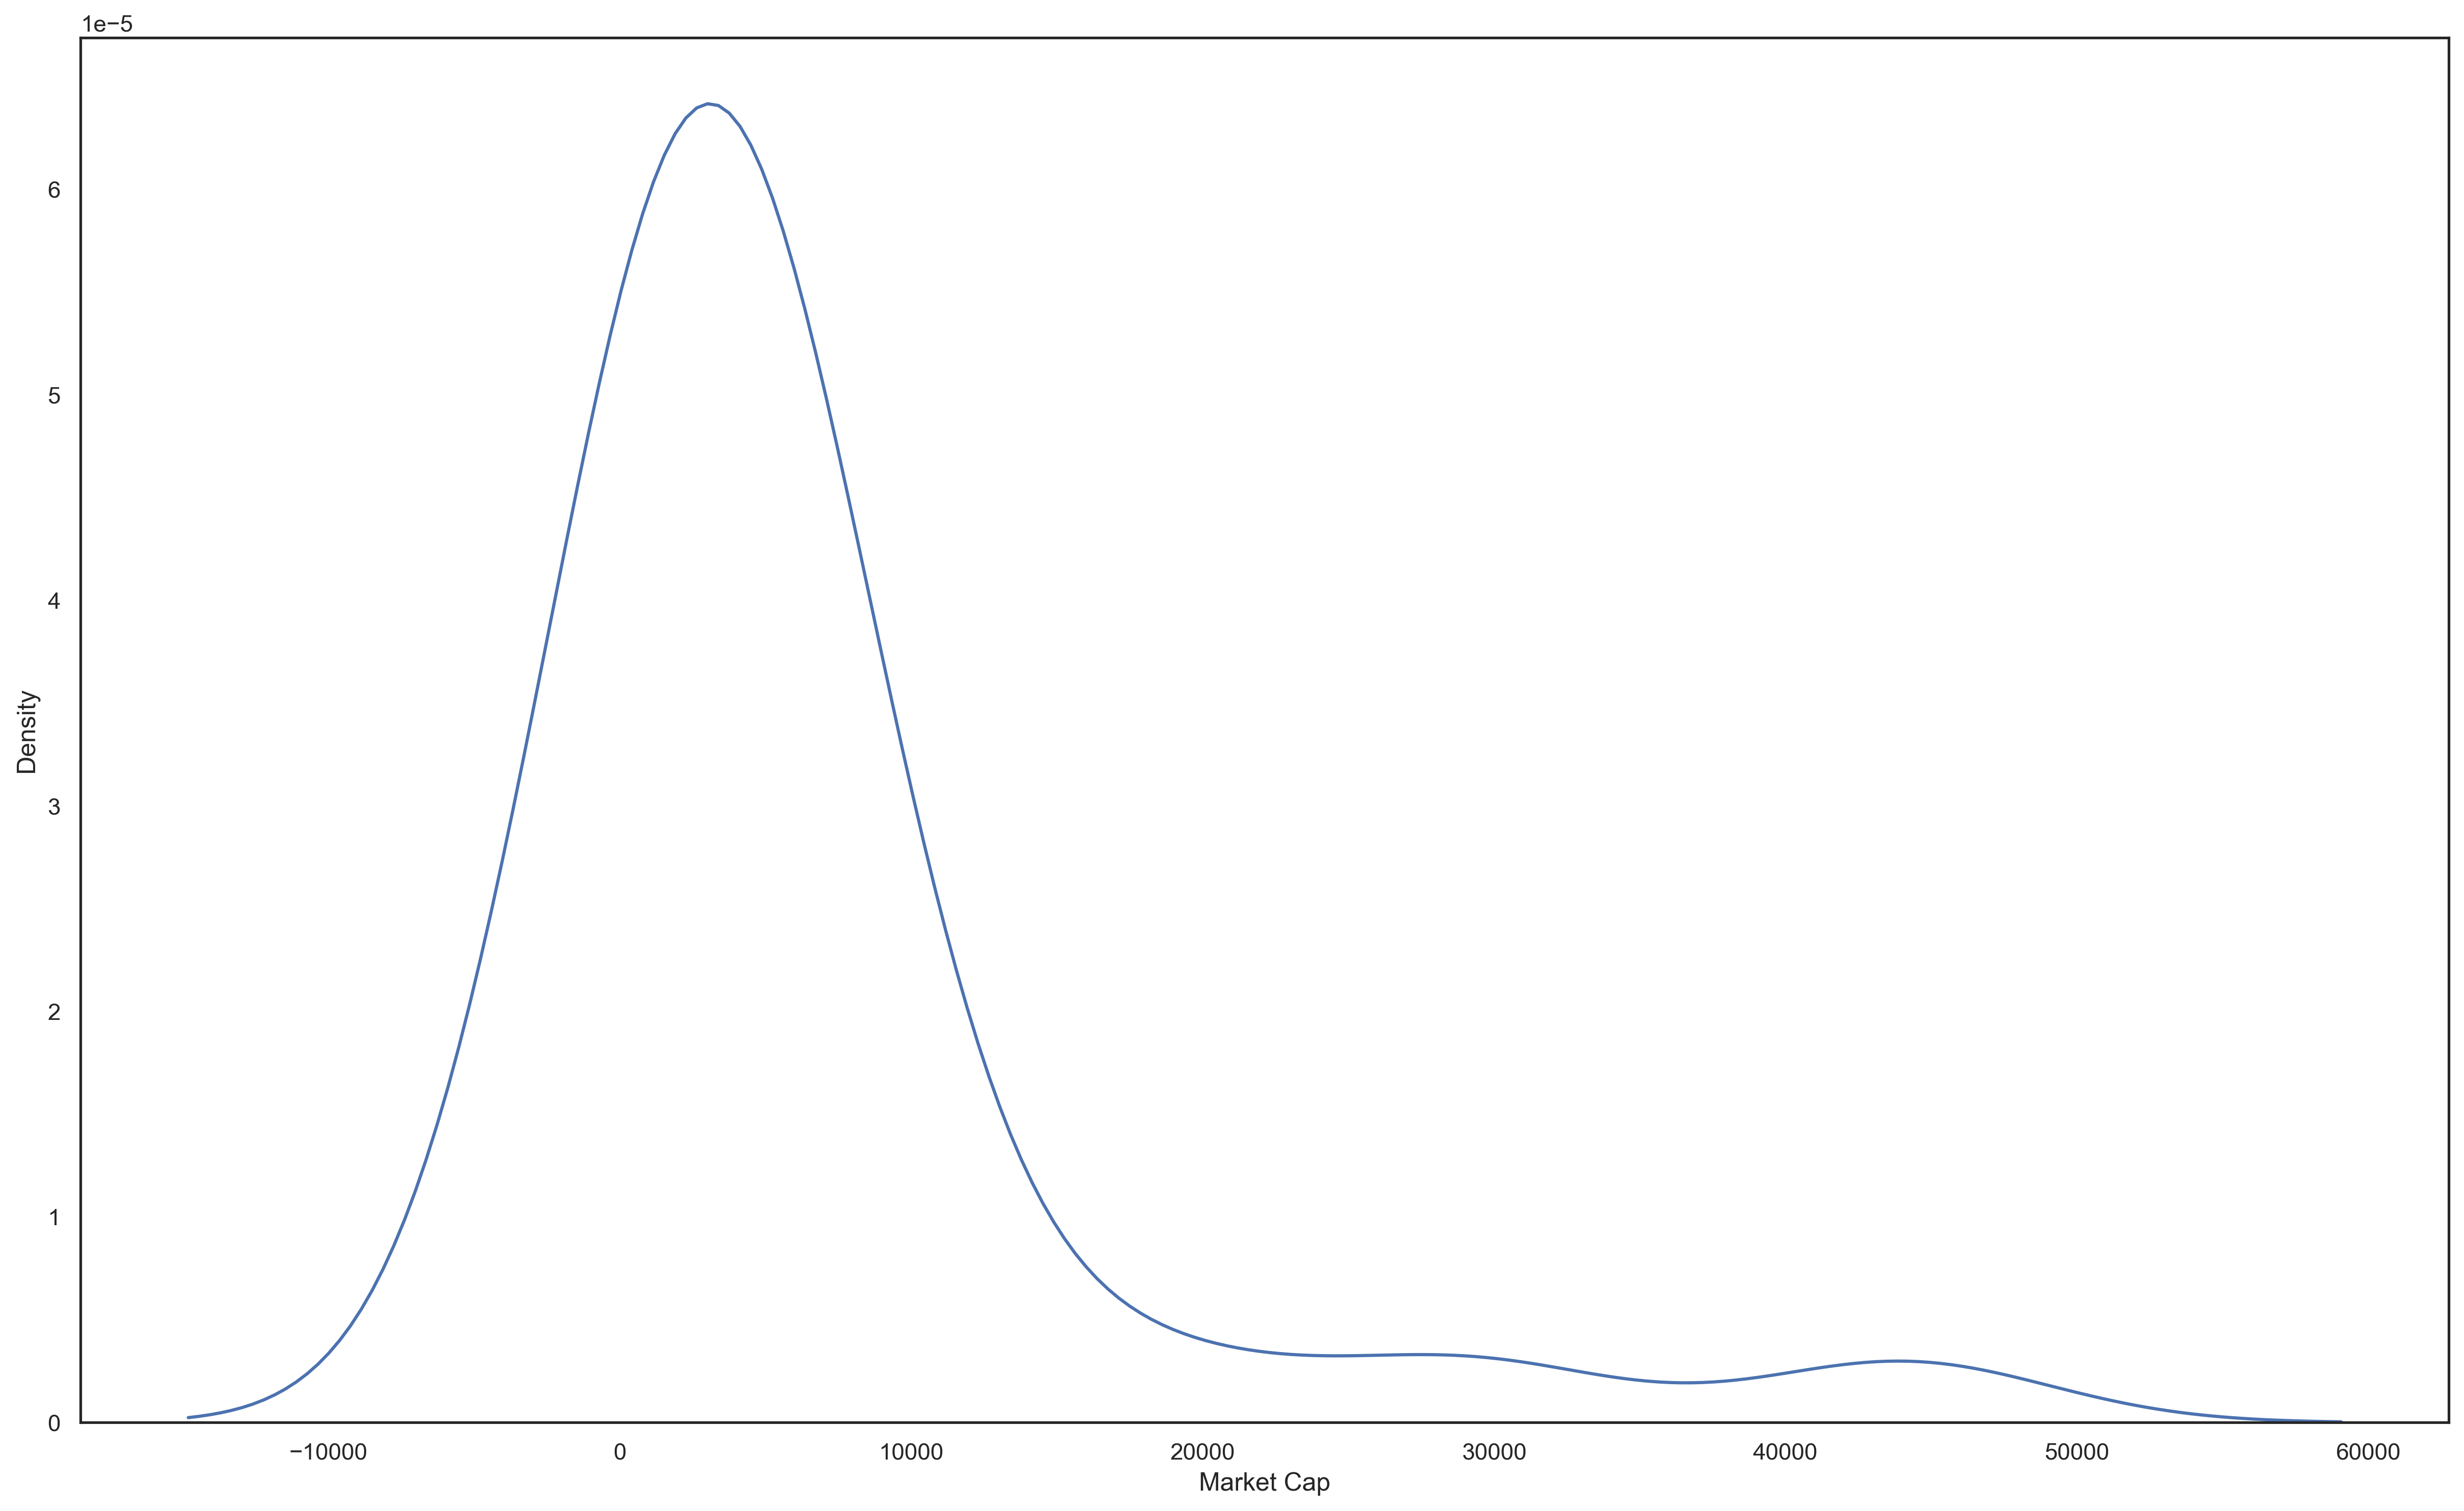

In [238]:
sns.kdeplot(reit['ROA'])
sns.kdeplot(reit['ROE'])
plt.show()
sns.kdeplot(reit['Market Cap'])
plt.show()

In [184]:
reit['Market Cap'].describe()

count       20.000000
mean      6336.729500
std       9191.212651
min         24.700000
25%        413.617500
50%       1960.000000
75%      10575.000000
max      29340.000000
Name: Market Cap, dtype: float64

In [185]:
reit25 = reit.loc[reit['Market Cap'] < 414]
reit50 = reit.loc[(reit['Market Cap'] < 1960) & (reit['Market Cap'] > 414)]
reit75 = reit.loc[(reit['Market Cap'] < 10575) & (reit['Market Cap'] > 1960)]
reitMax = reit.loc[(reit['Market Cap'] <= 29340) & (reit['Market Cap'] > 10575)]

<AxesSubplot:xlabel='ROA', ylabel='Density'>

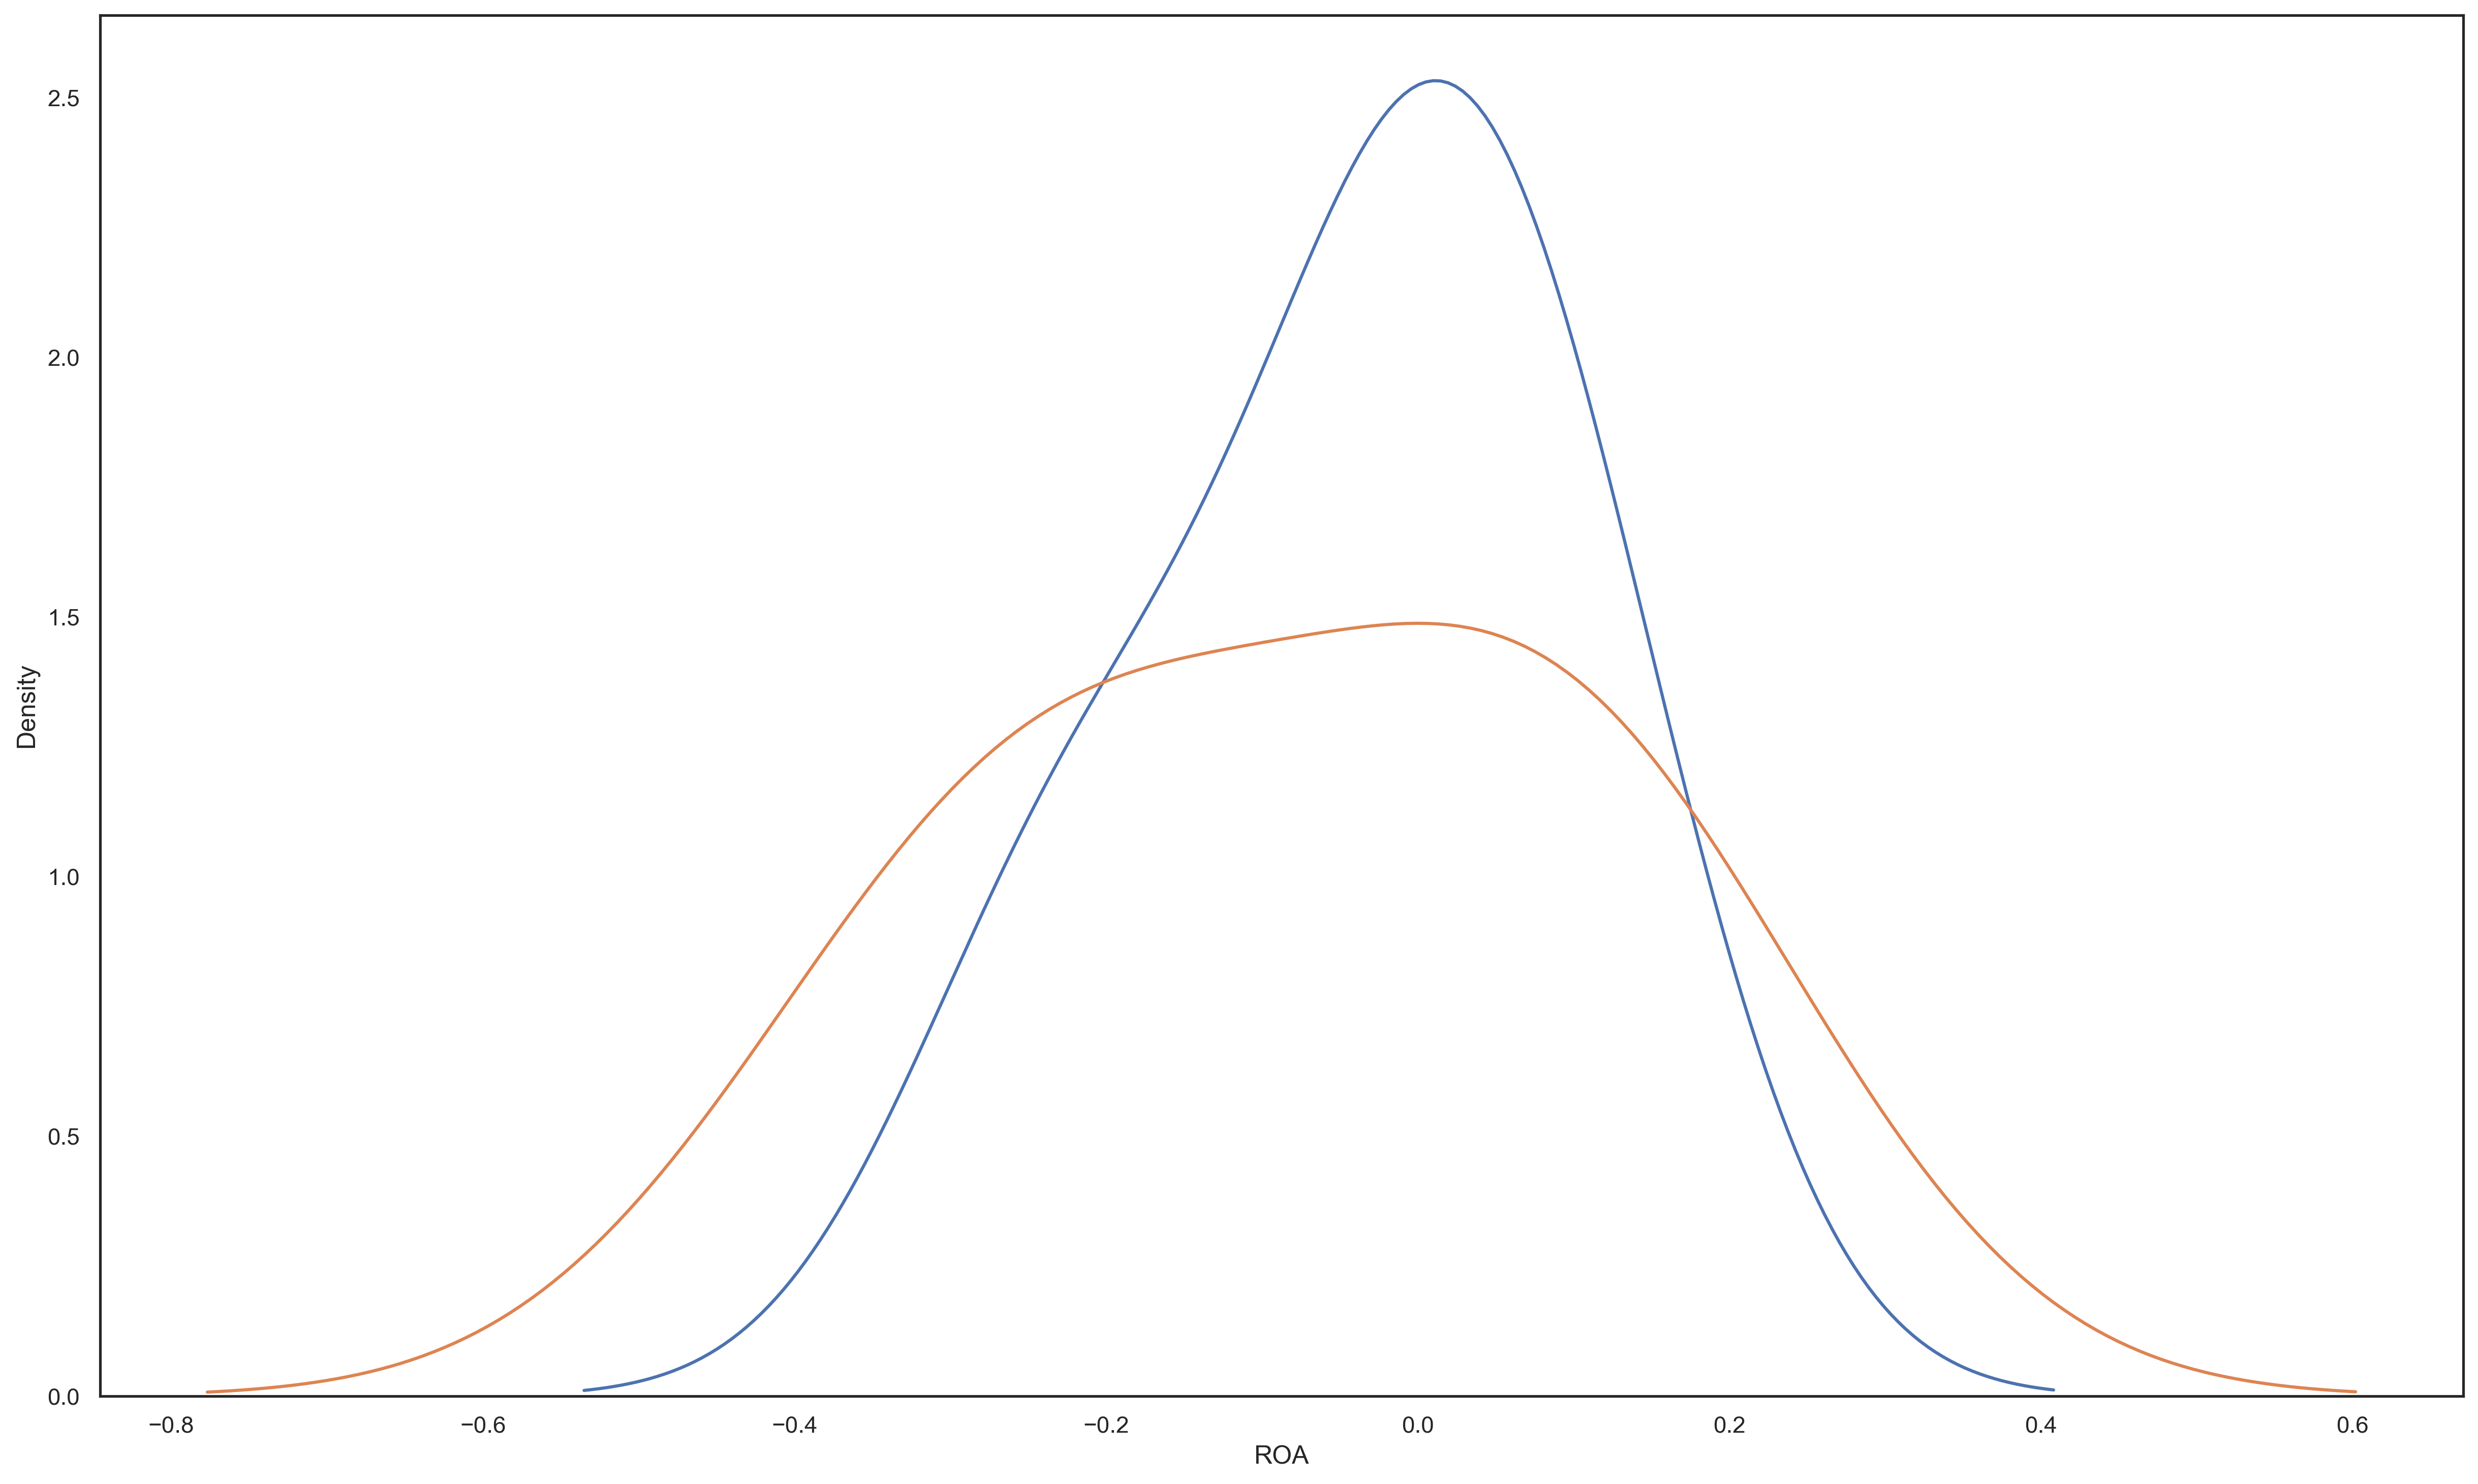

In [188]:
sns.kdeplot(reit75['ROA'])
sns.kdeplot(reit75['ROE'])

In [190]:
imputer = IterativeImputer(max_iter=3)
imp_arr = imputer.fit_transform(reit['Market Cap'].values.reshape(-1,1))
print(imp_arr)

[[   74.46  ]
 [ 6336.7295]
 [   95.36  ]
 [ 2060.    ]
 [29340.    ]
 [ 1860.    ]
 [ 3380.    ]
 [10210.    ]
 [ 3850.    ]
 [  807.98  ]
 [ 6336.7295]
 [  395.04  ]
 [ 2640.    ]
 [ 1320.    ]
 [ 6336.7295]
 [  280.82  ]
 [   24.7   ]
 [ 6336.7295]
 [ 6336.7295]
 [29300.    ]
 [14700.    ]
 [ 6336.7295]
 [  419.81  ]
 [11670.    ]
 [ 6336.7295]
 [13720.    ]
 [  586.42  ]]


In [131]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


In [127]:
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
X, y = load_iris(return_X_y=True)
mask = np.random.randint(0, 2, size=X.shape).astype(bool)
X[mask] = np.nan
X_train, X_test, y_train, _ = train_test_split(X, y, test_size=100,random_state=0)

transformer = FeatureUnion(transformer_list=[('features', SimpleImputer(strategy='mean')),
                                             ('indicators', MissingIndicator())])
transformer = transformer.fit(X_train, y_train)
results = transformer.transform(X_test)
results.shape

(100, 8)

In [128]:
clf = make_pipeline(transformer, DecisionTreeClassifier())
clf = clf.fit(X_train, y_train)
results = clf.predict(X_test)
results.shape

(100,)